In [ ]:
!python -m pip install tslearn

In [ ]:
%pip install h5py

In [323]:
from utilities import get_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, datetime, date
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks

In [284]:
DATA_PATH = get_path()

In [285]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

In [286]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10187873 entries, 0 to 10187872
Data columns (total 10 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   user_id                   object
 1   publication_date          object
 2   text                      object
 3   publication_date_in_secs  int64 
 4   retweet_count             int64 
 5   reply_count               int64 
 6   favorite_count            int64 
 7   num_hashtags              int64 
 8   num_urls                  int64 
 9   num_mentions              int64 
dtypes: int64(7), object(3)
memory usage: 777.3+ MB


In [287]:
start_2019 = pd.to_datetime(["20190101"]).astype(np.int64)[0]
end_2019 = pd.to_datetime(["20191231"]).astype(np.int64)[0]
df_tweets2019 = df_tweets[(df_tweets['publication_date_in_secs'] >= start_2019) & (df_tweets['publication_date_in_secs'] <= end_2019)]

In [288]:
df_users.id = df_users.id.astype(str)
df_merged = df_tweets2019.merge(df_users, left_on='user_id', right_on='id', how='right')

In [289]:
df_merged['publication_date_in_secs'].shape

(4514310,)

In [290]:
df_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4514310 entries, 0 to 4514309
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   user_id                    4509589 non-null  object 
 1   publication_date           4509589 non-null  object 
 2   text                       4411353 non-null  object 
 3   publication_date_in_secs   4509589 non-null  float64
 4   retweet_count              4509589 non-null  float64
 5   reply_count                4509589 non-null  float64
 6   favorite_count             4509589 non-null  float64
 7   num_hashtags               4509589 non-null  float64
 8   num_urls                   4509589 non-null  float64
 9   num_mentions               4509589 non-null  float64
 10  id                         4514310 non-null  object 
 11  name                       4514309 non-null  object 
 12  lang                       4514310 non-null  object 
 13  bot         

In [291]:
df_merged.user_id.fillna(-1, inplace=True)
users_list = df_merged.user_id.unique()
users_list = users_list.tolist()
users_list.remove(-1)

In [292]:
#users_list = df_grouped.user_id.unique().apply(int)
#users_list = users_list.explode().unique()

In [293]:
len(users_list)

6787

In [294]:
#For each user save the timeseries of pubblications
ts_pubblications = {}
df_grouped = df_merged.groupby(by=['user_id'])
for user in users_list:
    ts_pubblications[user] = df_grouped.get_group(str(user)).publication_date_in_secs.tolist()

In [295]:
# Cast publication date into date format
df_merged['publication_date'] = pd.to_datetime(df_merged.publication_date)
df_merged['publication_date'] = df_merged['publication_date'].dt.date

In [296]:
df_merged.user_id.fillna(-1, inplace=True)

In [297]:
df_merged

,user_id,publication_date,text,publication_date_in_secs,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,id,name,lang,bot,user_subscription,statuses_count,user_subscription_in_secs
0,2353593986,2019-07-11,"@4fri2endly0 ""A business that makes nothing bu...",1.562817e+18,0.0,0.0,0.0,0.0,0.0,1.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
1,2353593986,2019-06-21,"""Happiness is not a station you arrive at, but...",1.561104e+18,0.0,0.0,0.0,0.0,0.0,0.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
2,2353593986,2019-04-05,Music flow.,1.554468e+18,0.0,0.0,0.0,0.0,0.0,0.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
3,2353593986,2019-07-25,@_SimplyKC follow meeee...,1.564057e+18,0.0,0.0,0.0,0.0,0.0,1.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
4,2353593986,2019-04-29,"""You are the only person on earth who can use ...",1.556571e+18,0.0,0.0,0.0,0.0,0.0,0.0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514305,2383025796,2019-04-28,make up money could be going to so many other ...,1.556465e+18,0.0,0.0,0.0,0.0,0.0,0.0,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000
4514306,2383025796,2019-05-02,@dilligaf_life !,1.556808e+18,0.0,0.0,1.0,0.0,0.0,1.0,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000
4514307,2383025796,2019-04-27,I Thank God Everyday. I Know Where I Could've ...,1.556358e+18,0.0,0.0,0.0,0.0,0.0,0.0,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000
4514308,2383025796,2019-04-29,@itsJAYJAYbruh nice...,1.556534e+18,0.0,0.0,1.0,0.0,0.0,1.0,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000


In [369]:
def extract_daily_scores(df):

    day = date(2019,1,1)
    end = date(2019,12,31)

    success_scores = []

    df = df.groupby(by=['publication_date'])
    
    while day <= end:
        try:
            group = df.get_group(day)
            acceptance_score = group['retweet_count'].sum() + group['reply_count'].sum() + group['favorite_count'].sum()
            diffusion_score = group['num_hashtags'].sum() + group['num_mentions'].sum() + group['num_urls'].sum()
            success_scores.append(acceptance_score / (diffusion_score + 0.1))
        except KeyError:
            success_scores.append(-1)

        day = day + timedelta(days=1)

    return success_scores
        

In [370]:
def extract_users_scores(df):

    df_grouped_pub_day = df.groupby(by=['user_id'])
    users_scores = {}
    
    # Extract for each user a timeseries of daily scores about tweets of 2019
    for user in users_list:
        user_group = df_grouped_pub_day.get_group(str(user))
        users_scores[user] = extract_daily_scores(user_group)
    
    return users_scores


In [371]:
res = extract_users_scores(df_merged)

In [372]:
df_timeseries = pd.DataFrame(res.items())

In [373]:
df_timeseries.head()

,0,1
0,2353593986,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,2358850842,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,466124818,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,2199062688,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,2357425536,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [374]:
df_timeseries['publications'] = df_timeseries[0].map(ts_pubblications)

In [375]:
df_timeseries.head()

,0,1,publications
0,2353593986,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.562816946e+18, 1.561104313e+18, 1.55446806e..."
1,2358850842,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563961546e+18, 1.556421671e+18, 1.556749642..."
2,466124818,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.571747079e+18, 1.562044389e+18, 1.567421266..."
3,2199062688,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.564036843e+18, 1.561534888e+18, 1.561055373..."
4,2357425536,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563345763e+18, 1.554433812e+18, 1.562575589..."


In [376]:
df_timeseries.rename(columns={0: 'user_id', 1: 'success_scores'}, inplace=True)

In [377]:
df_timeseries.head()

,user_id,success_scores,publications
0,2353593986,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.562816946e+18, 1.561104313e+18, 1.55446806e..."
1,2358850842,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563961546e+18, 1.556421671e+18, 1.556749642..."
2,466124818,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.571747079e+18, 1.562044389e+18, 1.567421266..."
3,2199062688,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.564036843e+18, 1.561534888e+18, 1.561055373..."
4,2357425536,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1.563345763e+18, 1.554433812e+18, 1.562575589..."


In [378]:
df_timeseries.to_csv(path_or_buf=DATA_PATH+'tweets_timeseries.csv', sep='#', index=False)

In [379]:
df_timeseries = pd.read_csv(DATA_PATH+'tweets_timeseries.csv', sep='#')

In [380]:
X = random_walks(n_ts=60, sz=40)
X.shape

(60, 40, 1)

In [381]:
ts_list = df_timeseries.success_scores.values

In [383]:
timeseries_list = []
for i, item in enumerate(ts_list):
    timeseries_list.append(eval(item))
    timeseries_list[i] = np.array(timeseries_list[i], dtype=object)

In [388]:
timeseries_list = np.array(timeseries_list, dtype=object)
timeseries_matrix = np.asmatrix(timeseries_list)
timeseries_matrix.shape

(6787, 365)

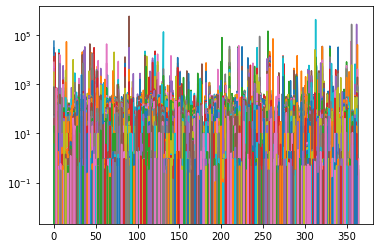

In [391]:
plt.plot(timeseries_matrix.reshape(timeseries_matrix.shape[1], timeseries_matrix.shape[0]))
plt.yscale('log')
plt.show()

In [393]:
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=10, random_state=0)
km.fit(timeseries_list)

TimeSeriesKMeans(max_iter=10, n_clusters=5, random_state=0)

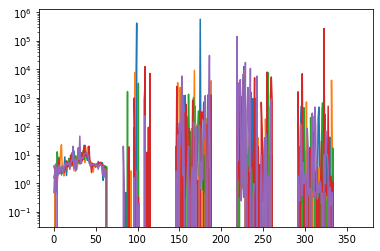

In [395]:
plt.plot(km.cluster_centers_.reshape(timeseries_list.shape[1], 5))
plt.yscale('log')
plt.show()

In [396]:
km_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(timeseries_list)

MemoryError: Unable to allocate 1.02 MiB for an array with shape (365, 365) and data type float64

In [ ]:
plt.plot(km_dtw.cluster_centers_.reshape(timeseries_list.shape[1], 5))
plt.show()

In [ ]:
km.inertia_

In [ ]:
km_dtw.inertia_